
=== Case: delta ===


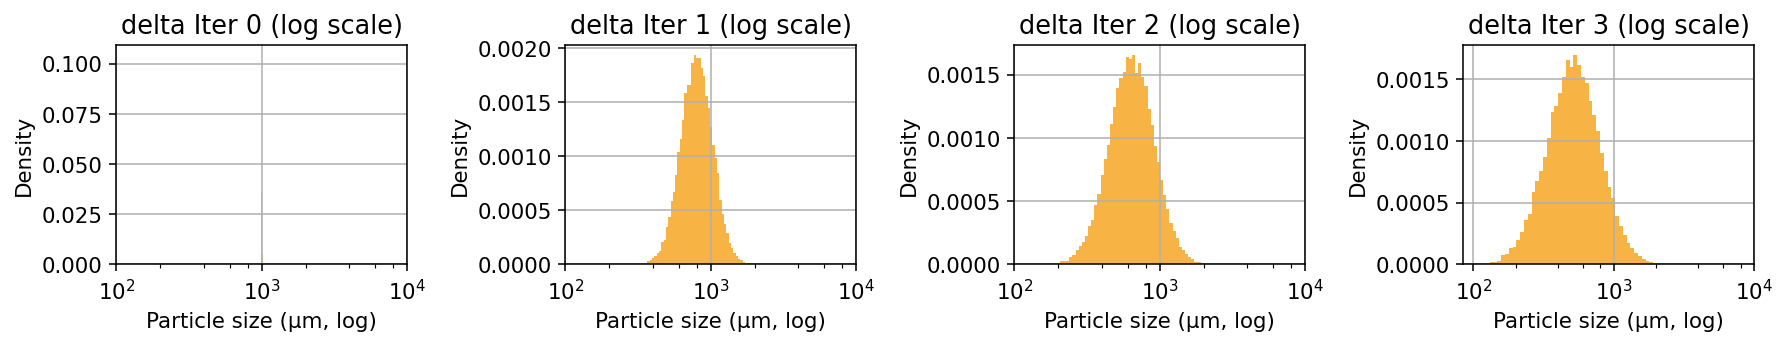

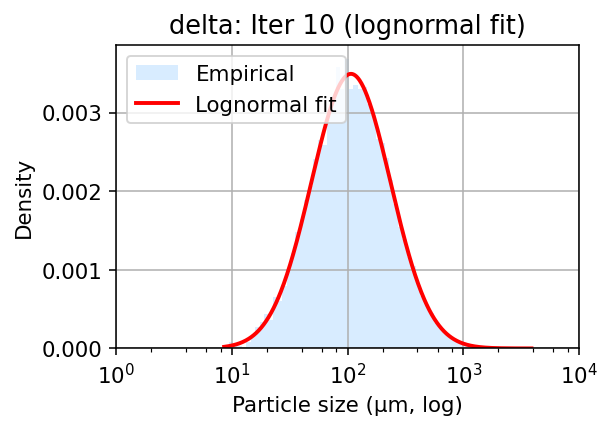

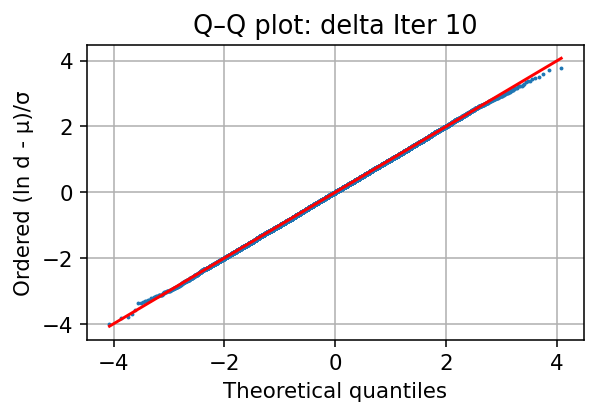

[delta Iter 10] KS stat=0.004, p=0.826 | d50≈198 µm, GSD≈2.19

=== Case: uniform ===


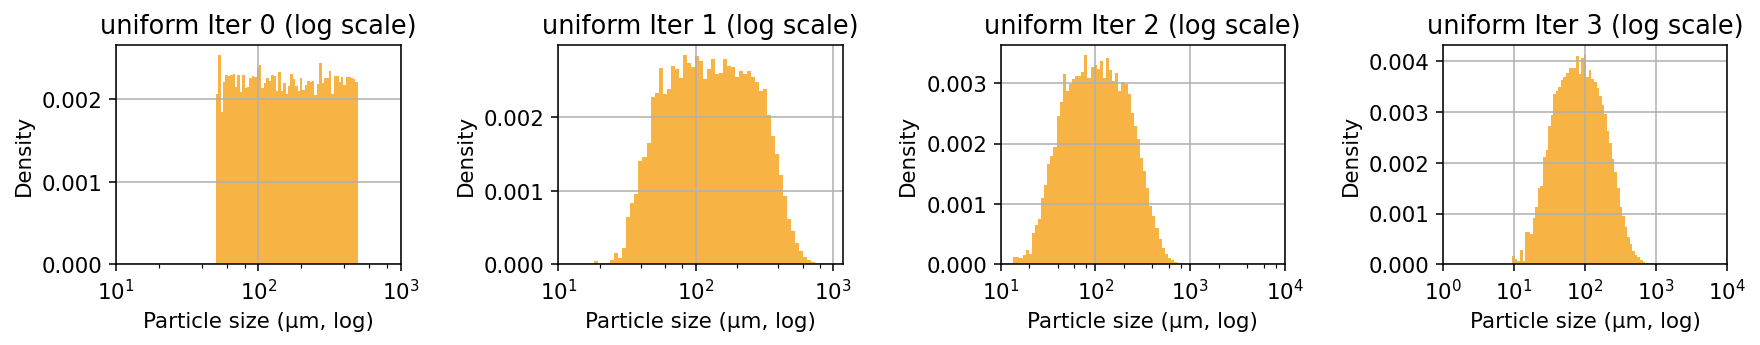

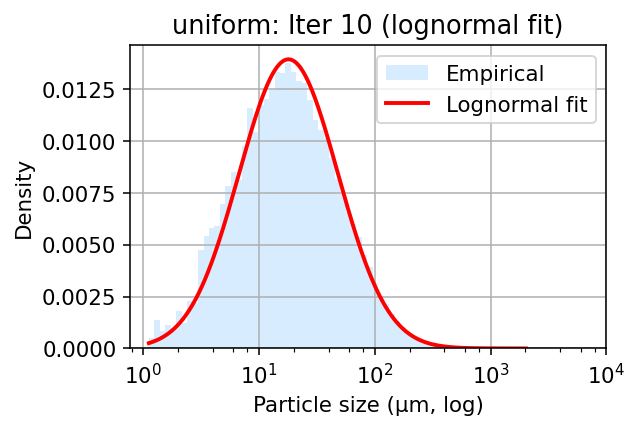

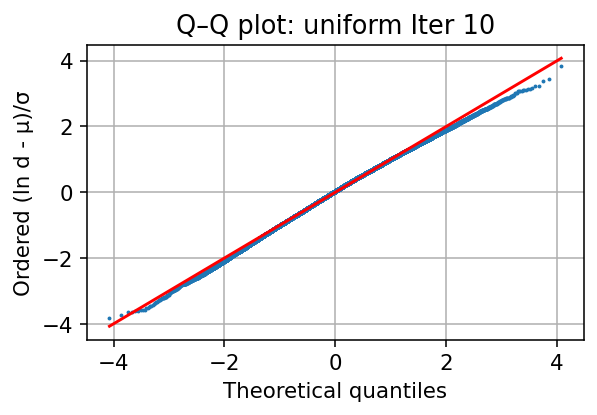

[uniform Iter 10] KS stat=0.017, p=1.48e-07 | d50≈47.2 µm, GSD≈2.67

=== Case: bimodal ===


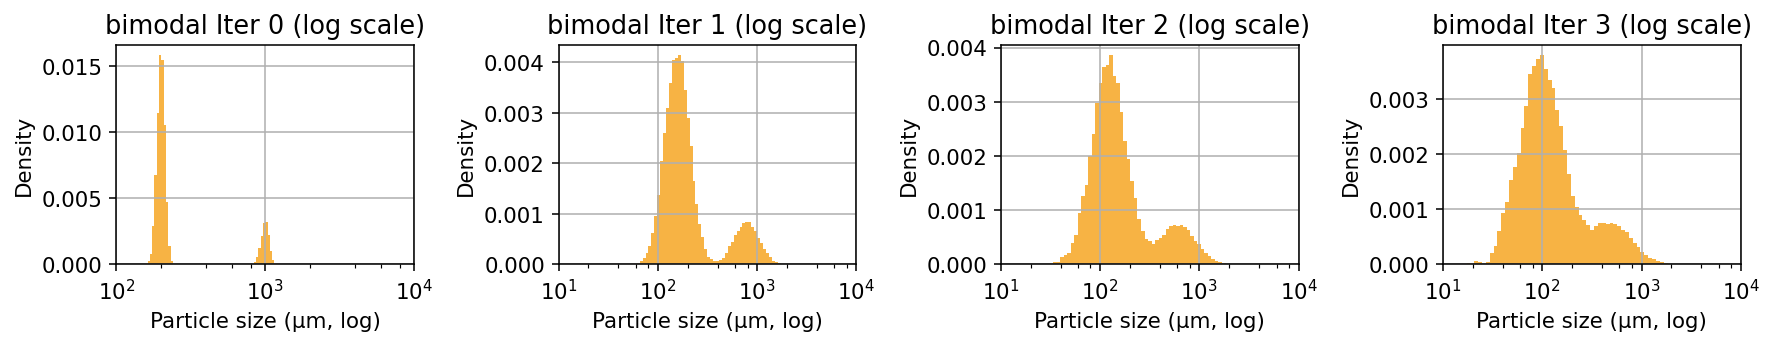

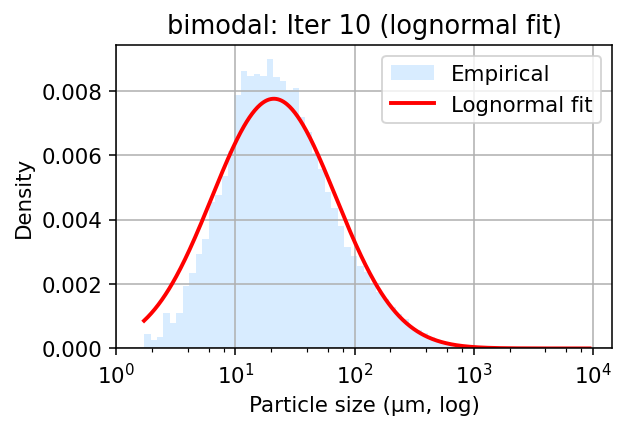

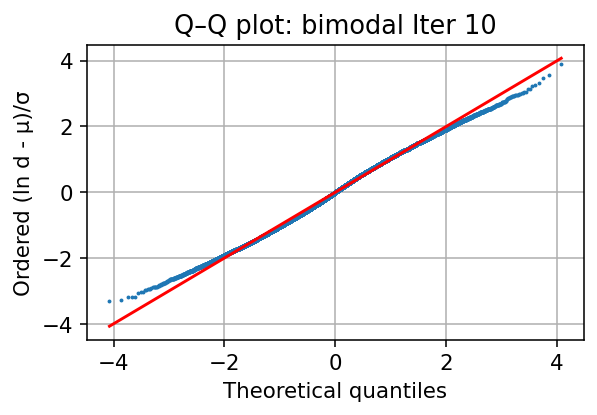

[bimodal Iter 10] KS stat=0.021, p=1.12e-11 | d50≈88 µm, GSD≈3.31


In [1]:
# ============================================
# Lognormalization by Multiplicative CLT (v2)
# --------------------------------------------
# Purpose:
#   Repeated multiplicative changes (d_{t+1} = d_t * R_t) make ln(d)
#   converge to a normal distribution (CLT) => d becomes lognormal.
#
# Run:
#   - Works on Google Colab without extra installs.
#   - Shows convergence on log-scale histograms, and fits a lognormal
#     on the final iteration with a QQ-plot + KS statistic, d50, GSD.
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation, NullFormatter
from scipy import stats

np.random.seed(0)
plt.rcParams.update({"figure.dpi": 140, "font.size": 11, "axes.grid": True})

def set_log_ticks(ax, xmin: float, xmax: float, max_decades: int = 6) -> None:
    """Readable log ticks: keep several major ticks and hide minor labels."""
    lo = int(np.floor(np.log10(xmin)))
    hi = int(np.ceil(np.log10(xmax)))
    step = max(1, int(np.ceil((hi - lo) / max_decades)))
    majors = [10 ** k for k in range(lo, hi + 1, step)]
    ax.set_xscale("log")
    ax.set_xticks(majors)
    ax.xaxis.set_major_formatter(LogFormatterSciNotation())
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(.2, .4, .6, .8)))
    ax.xaxis.set_minor_formatter(NullFormatter())

def make_initial(case: str = "delta", n: int = 30000) -> np.ndarray:
    """Initial particle sizes in µm for three scenarios."""
    if case == "delta":
        return np.full(n, 1000.0) * (1 + np.random.normal(0, 0.004, n))
    if case == "uniform":
        return np.random.uniform(50.0, 500.0, n)
    if case == "bimodal":
        a = np.random.normal(200.0, 12.0, n // 2)
        b = np.random.normal(1000.0, 60.0, n // 2)
        x = np.concatenate([a, b])
        return x[x > 0]
    raise ValueError("case must be 'delta', 'uniform', or 'bimodal'")

def multiplicative_process(
    d0: np.ndarray, iters: int = 10,
    mu_logR: float = np.log(0.85), sigma_logR: float = 0.25
) -> list[np.ndarray]:
    """Simulate ln(d_{t+1}) = ln(d_t) + Normal(mu_logR, sigma_logR^2)."""
    y = np.log(np.asarray(d0, float))
    out = [np.exp(y)]
    for _ in range(iters):
        y += np.random.normal(mu_logR, sigma_logR, y.size)
        out.append(np.exp(y))
    return out

def plot_progress_log(sizes_list: list[np.ndarray], case: str) -> None:
    """Show first 4 iterations on log-x histograms (visual convergence)."""
    cols = min(4, len(sizes_list))
    fig, axes = plt.subplots(1, cols, figsize=(3.2 * cols, 2.6))
    for i, (ax, s) in enumerate(zip(axes, sizes_list[:cols])):
        s = np.asarray(s); s = s[(s > 0) & np.isfinite(s)]
        bins = np.geomspace(s.min(), s.max(), 60)
        ax.hist(s, bins=bins, density=True, color="#f6a623", alpha=0.85)
        set_log_ticks(ax, s.min(), s.max())
        ax.set_title(f"{case} Iter {i} (log scale)")
        ax.set_xlabel("Particle size (µm, log)"); ax.set_ylabel("Density")
    plt.tight_layout(); plt.show()

def analyze_lognormal(sizes: np.ndarray, case: str, label: str = "final") -> dict:
    """MLE fit of lognormal + QQ plot + KS statistic, and d50/GSD reporting."""
    s = np.asarray(sizes); s = s[(s > 0) & np.isfinite(s)]
    y = np.log(s); mu, sig = y.mean(), y.std(ddof=0)

    fig, ax = plt.subplots(1, 1, figsize=(4.6, 3.2))
    bins = np.geomspace(s.min(), s.max(), 70)
    ax.hist(s, bins=bins, density=True, color="#cfe8ff", alpha=0.8, label="Empirical")
    xs = np.geomspace(s.min(), s.max(), 500)
    pdf = (1/(xs*sig*np.sqrt(2*np.pi))) * np.exp(-(np.log(xs)-mu)**2/(2*sig*sig))
    ax.plot(xs, pdf, "r-", lw=2, label="Lognormal fit")
    set_log_ticks(ax, s.min(), s.max())
    ax.set_title(f"{case}: Iter {label} (lognormal fit)")
    ax.set_xlabel("Particle size (µm, log)"); ax.set_ylabel("Density"); ax.legend()
    plt.tight_layout(); plt.show()

    z = (y - mu)/sig
    (osm, osr), _ = stats.probplot(z, dist="norm")
    fig, ax = plt.subplots(1, 1, figsize=(4.4, 3.1))
    ax.plot(osm, osr, ".", ms=2)
    lo, hi = min(osm.min(), osr.min()), max(osm.max(), osr.max())
    ax.plot([lo, hi], [lo, hi], "r-")
    ax.set_title(f"Q–Q plot: {case} Iter {label}")
    ax.set_xlabel("Theoretical quantiles"); ax.set_ylabel("Ordered (ln d - μ)/σ")
    plt.tight_layout(); plt.show()

    ks, p = stats.kstest(z, "norm")
    d50, gsd = float(np.exp(mu)), float(np.exp(sig))
    print(f"[{case} Iter {label}] KS stat={ks:.3f}, p={p:.3g} | d50≈{d50:.3g} µm, GSD≈{gsd:.3g}")
    return {"mu": float(mu), "sigma": float(sig), "d50": d50, "GSD": gsd, "KS": float(ks), "p": float(p)}

if __name__ == "__main__":
    scenarios = [
        ("delta",   dict(iters=10, sigma_logR=0.25)),
        ("uniform", dict(iters=10, sigma_logR=0.25)),
        ("bimodal", dict(iters=10, sigma_logR=0.28)),
    ]
    for case, cfg in scenarios:
        print(f"\n=== Case: {case} ===")
        d0 = make_initial(case)
        s_list = multiplicative_process(d0, iters=cfg["iters"], sigma_logR=cfg["sigma_logR"])
        plot_progress_log(s_list, case)                  # Figures 1/4/7 相当
        _ = analyze_lognormal(s_list[-1], case, label=str(cfg["iters"]))  # Figures 2/5/8, 3/6/9
